In [32]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import random 
from sklearn.model_selection import train_test_split

In [33]:
#part 1
def sigmoid(z):
    return 1./(1. + np.exp(-z))

In [34]:
#part 2
def initialize_parameters(n_x,n_h,n_out,active_fun_hide,active_fun_out):
    W_hide = np.random.randn(n_h, n_x+1) 
    W_out = np.random.randn(n_out, n_h+1) 
    parameters = {"W_hide": W_hide,
                 "W_out":W_out,
                  "delta_W_hide_ago":np.zeros((n_h, n_x+1))  ,
                  "delta_W_out_ago":np.zeros((n_out, n_h+1)) ,
                 "act_func_hide":active_fun_hide,
                 "act_func_out":active_fun_out}
    dw_out=np.zeros((n_out,n_h+1))
    dw_hide=np.zeros((n_h,n_x+1))
    return parameters

In [35]:
#part 3
def forward_propagation(X, parameters):
    X=np.append(np.ones((X.shape[0],1)),X,axis=1)
    z_hide = np.dot(parameters["W_hide"],X.T)
    if parameters['act_func_hide'] =='tanh':
        A_hide = np.tanh(z_hide)
    else:
        A_hide = sigmoid(z_hide)
    A_hide_b = np.append(np.ones((1,X.shape[0])),A_hide,axis=0)
    z_out = np.dot(parameters["W_out"],A_hide_b)
    if parameters['act_func_out']=='liner':
        A_out = z_out
    elif parameters['act_func_out']=='tanh':
        A_out = np.tanh(z_out)
    else:
        A_out = sigmoid(z_out)
    cache = {"z_hide": z_hide,
         "A_hide": A_hide,
         "z_out": z_out,
         "A_out": A_out}
    return A_out,cache

In [36]:
#part 4
def square_error_loss(y_true, y_pred):
    return (y_true - y_pred) ** 2

In [37]:
#part 5
def mean_square_error(y_true, y_pred):
    return np.sum(square_error_loss(y_true, y_pred)) / len(y_pred)

In [38]:
# part 6
def backward_propagation(parameters,cache, X, Y):
    m = X.shape[0]
    X=np.append(np.ones((X.shape[0],1)),X,axis=1)
    dL=-(Y-cache['A_out'])
    if parameters['act_func_hide'] =='tanh':
        dz_out = 1-np.power(cache['A_out'],2)
    else:
        dz_out=cache['A_out']*(1.0-cache['A_out'])
    dw_out=(1/m) * (np.dot(dL*dz_out,np.append(np.ones((1,X.shape[0])),cache['A_hide'],axis=0).T))
    if parameters['act_func_out']=='liner':
        dz_hide = cache['A_hide']
    elif parameters['act_func_out']=='tanh':
        dz_hide = 1-np.power(cache['A_hide'],2)
    else:
        dz_hide = cache['A_hide']*(1.0-cache['A_hide'])

    buffer=dL*np.dot(parameters['W_out'][:,1:].T,dz_out)
    buffer=buffer * dz_hide
    dw_hide=(1/m) * np.dot(buffer,X)
    grads = {"dw_out": dw_out,
             "dw_hide": dw_hide,}
    
    return grads

In [39]:
# part 7
def update_parameters(parameters, grads):
    dw_hide = grads["dw_hide"]
    dw_out = grads["dw_out"]
    W_hide = parameters["W_hide"]
    W_out = parameters["W_out"]
    delat_W_hide =np.power(parameters['reduction_factor'],parameters['epoch']) * parameters['learning_rate'] * dw_hide + parameters['gama'] * parameters["delta_W_hide_ago"]
    delat_W_out =np.power(parameters['reduction_factor'],parameters['epoch']) * parameters['learning_rate'] * dw_out + parameters['gama'] * parameters["delta_W_out_ago"]
    W_hide = W_hide - delat_W_hide
    W_out = W_out - delat_W_out
    parameters["delta_W_hide_ago"]=delat_W_hide
    parameters["delta_W_out_ago"]=delat_W_out
    parameters['W_hide'] =  W_hide
    parameters['W_out'] =  W_out
    return parameters

In [40]:
# part 8
def predict(parameters, X):
    A_out , cache = forward_propagation(X,parameters)
    for elm in A_out:
        elm = (elm > 0.5)
    return (elm *1)

In [41]:
data = pd.read_csv('c:\\Users\\Lenovo\Desktop\\problem2.csv')
X = data.iloc[:, [0, 1]].values 
y = data.iloc[:, 2].values             

In [42]:
# part 9
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 112)

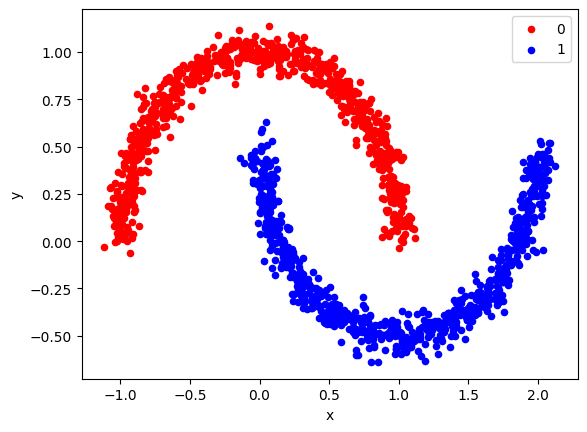

In [43]:
# part 10
df=pd.DataFrame(dict(x=X[:,0],y=X[:,1], label =y))
colors ={0:'red' , 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key , group in grouped:
    group.plot(ax=ax , kind = 'scatter' , x= 'x' ,y='y' , label=key ,color=colors[key])
plt.show()

In [44]:
# part 11
def accurecy(parameters,X,y):
    true_detect=0
    for index,x in enumerate(X):
        if predict(parameters,X[[index]]) == y[index]:
            true_detect+=1
    return true_detect/X.shape[0]

In [45]:
# part 12
def nn_model(X, y , nerun_hide,nerun_out, epochs = 20,act_hide='sig',
             act_out='sig',mode='online', print_cost=False , learning_rate = 0.3,threshold=0.999,reduction_factor=1,gama=0):
    nerun_input = X.shape[1]
    parameters = initialize_parameters(nerun_input,nerun_hide,nerun_out,act_hide,act_out)
    parameters['learning_rate'] = learning_rate
    parameters['threshold'] = threshold
    parameters['reduction_factor'] = reduction_factor
    parameters['epochs'] = epochs
    parameters['gama']=gama
    parameters_max_mse = parameters
    cost=math.inf
    mse_i=[]
    if mode == 'online':
        for i in range(parameters['epochs']):
            parameters['epoch']=i
            for j in range(X.shape[0]):
                index=random.sample(range(X.shape[0]), 1)
                A_hide, cache = forward_propagation(X[index],parameters)
                grads = backward_propagation(parameters, cache, X[index], y[index])
                parameters = update_parameters(parameters, grads)
            
            cost=mean_square_error(A_hide, y,)
            mse_i.append(cost)
            if mean_square_error(A_hide, y,)< cost:    
                parameters_max_mse=parameters
            a=accurecy(parameters,X,y)
            if a >= parameters['threshold']:
                break;
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    else:
        for i in range(parameters['epochs']):
            parameters['epoch']=i
            A_hide, cache = forward_propagation(X,parameters)
            grads = backward_propagation(parameters, cache, X, y)
            parameters = update_parameters(parameters , grads )
            cost=mean_square_error(A_hide, y,)
            mse_i.append(cost)
            if mean_square_error(A_hide, y,)< cost:
                parameters_max_mse=parameters
            a=accurecy(parameters,X,y)
            if a >= parameters['threshold']:
                    break;
            if print_cost: 
                print ("Cost after iteration %i: %f" %(i, cost))
    plt.figure()
    plt.plot(np.arange(0, parameters['epoch']+1,1, dtype=int), mse_i)
    plt.xlabel('epoch')
    plt.ylabel('Squared Error')
    plt.show()
    return parameters_max_mse

In [46]:
# part 13
def plot_decision_boundary_nn(parameters, X, Y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    Z = predict(parameters, grid_points)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)

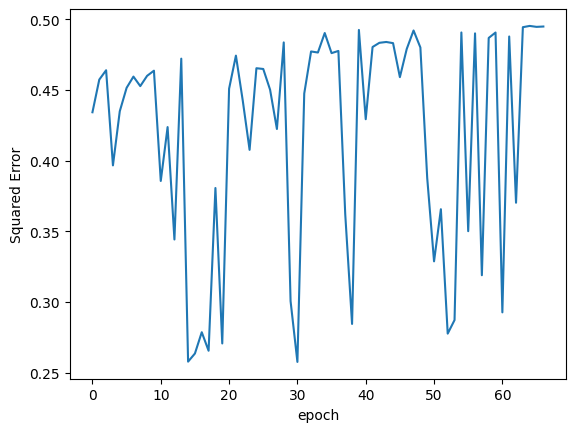

1.0


In [47]:
# part 14
parameters_sig_sig_online_learningFix=nn_model(x_train, y_train,nerun_hide=3,nerun_out=1,epochs=200,
                                   act_hide='sig',act_out='sig',mode='online',print_cost=False,
                                   learning_rate =0.6)
print(accurecy(parameters_sig_sig_online_learningFix,x_test,y_test))

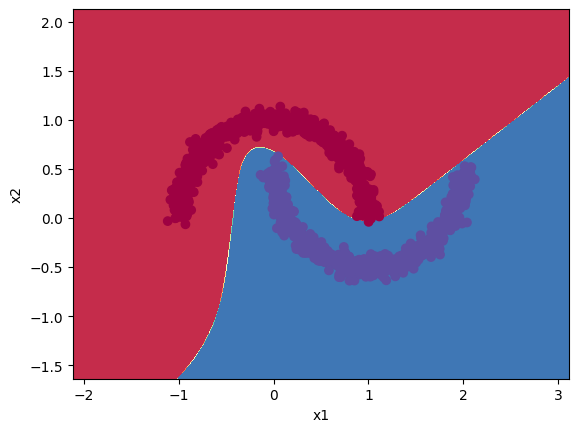

In [48]:
# part 15
plot_decision_boundary_nn(parameters_sig_sig_online_learningFix, X, y)

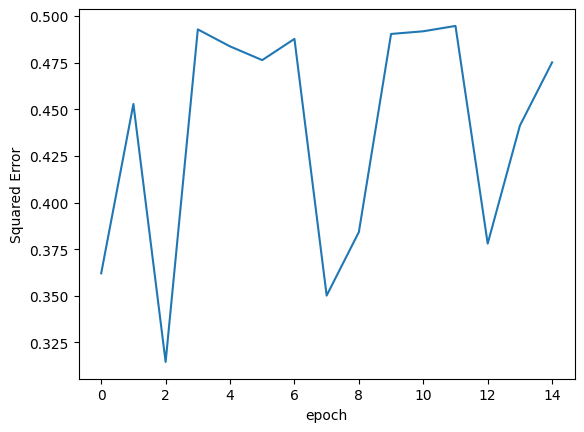

1.0


In [49]:
# part 16
parameters_sig_sig_online_learningNotFix=nn_model(x_train, y_train,nerun_hide=3,nerun_out=1,epochs=100,
                                   act_hide='sig',act_out='sig',mode='online',print_cost=False,
                                   learning_rate =5, reduction_factor = 0.9)
print(accurecy(parameters_sig_sig_online_learningNotFix,x_test,y_test))

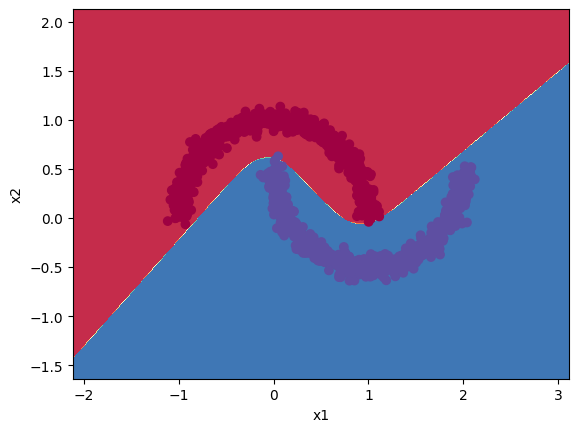

In [50]:
# part 17
plot_decision_boundary_nn(parameters_sig_sig_online_learningNotFix, X, y)

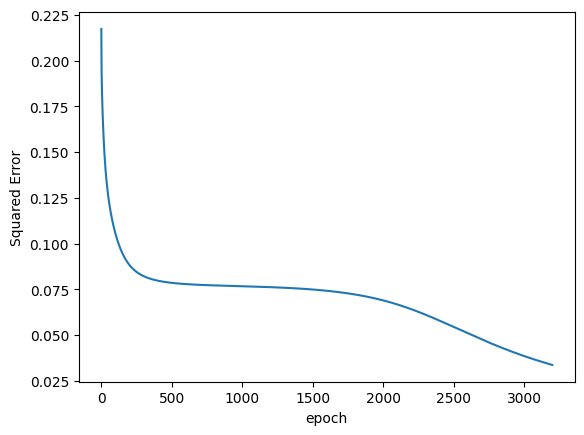

0.96


In [51]:
# part 18
parameters_sig_sig_batch_learningFix=nn_model(x_train, y_train,nerun_hide=8,nerun_out=1,epochs=3200,
                                 act_hide='sig',act_out='sig',mode='batch',print_cost=False,
                                 learning_rate =1.3)
print(accurecy(parameters_sig_sig_batch_learningFix,x_test,y_test))

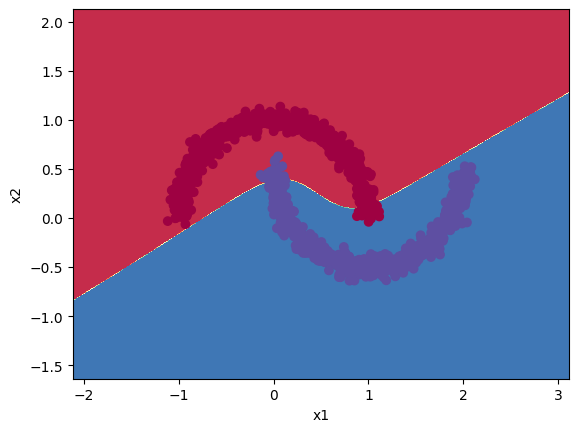

In [52]:
# part 19
plot_decision_boundary_nn(parameters_sig_sig_batch_learningFix, X, y)

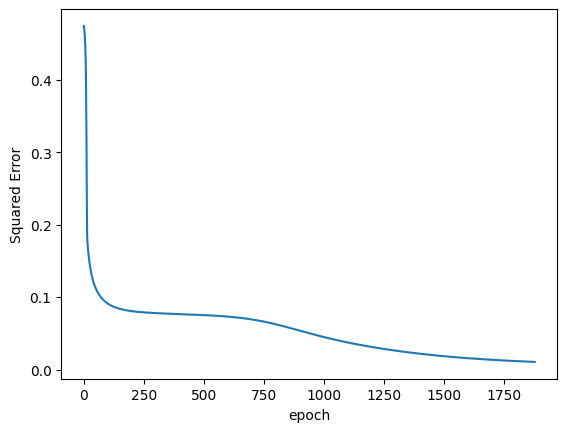

1.0


In [53]:
# part 20
parameters_sig_sig_batch_learningNotFix=nn_model(x_train, y_train,nerun_hide=8,nerun_out=1,epochs=2000,
                                 act_hide='sig',act_out='sig',mode='batch',print_cost=False,
                                 learning_rate =3, reduction_factor = 0.999999)
print(accurecy(parameters_sig_sig_batch_learningNotFix,x_test,y_test))

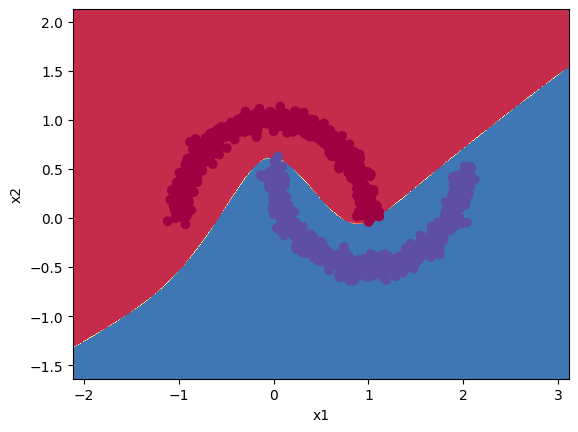

In [54]:
# part 21
plot_decision_boundary_nn(parameters_sig_sig_batch_learningNotFix, X, y)

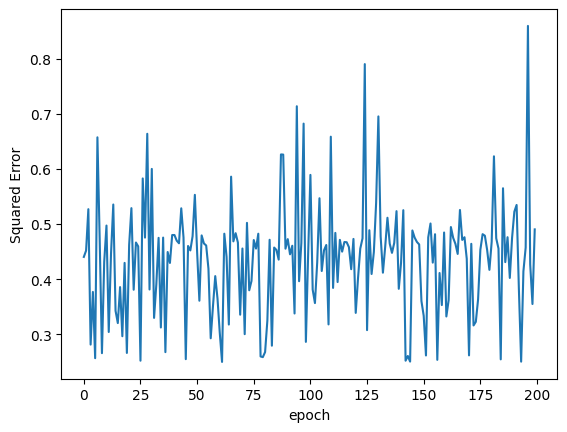

0.8911111111111111


In [55]:
# part 22
parameters_tanh_tanh_online_learningFix=nn_model(x_train, y_train,nerun_hide=3,nerun_out=1,epochs=200,
                                     act_hide='tanh',act_out='tanh',mode='online',print_cost=False,
                                     learning_rate = 0.3)
print(accurecy(parameters_tanh_tanh_online_learningFix,x_test,y_test))

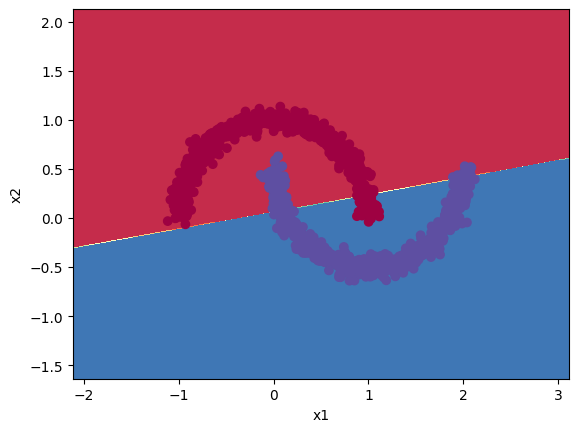

In [56]:
# part 23
plot_decision_boundary_nn(parameters_tanh_tanh_online_learningFix, X, y)

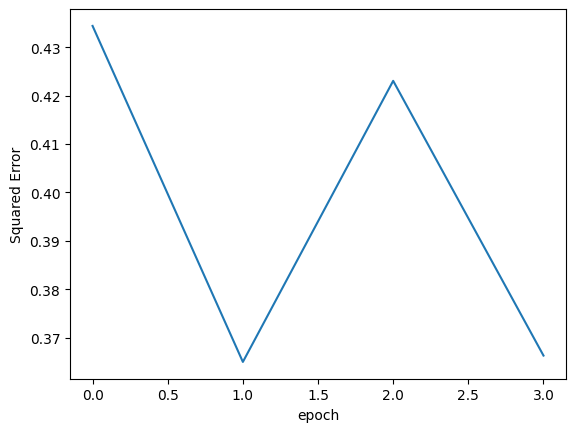

1.0


In [57]:
# part 24
parameters_tanh_tanh_online_learningNotFix=nn_model(x_train, y_train,nerun_hide=3,nerun_out=1,epochs=100,
                                     act_hide='tanh',act_out='tanh',mode='online',print_cost=False,
                                     learning_rate = 0.39, reduction_factor = 0.8)
print(accurecy(parameters_tanh_tanh_online_learningNotFix,x_test,y_test))

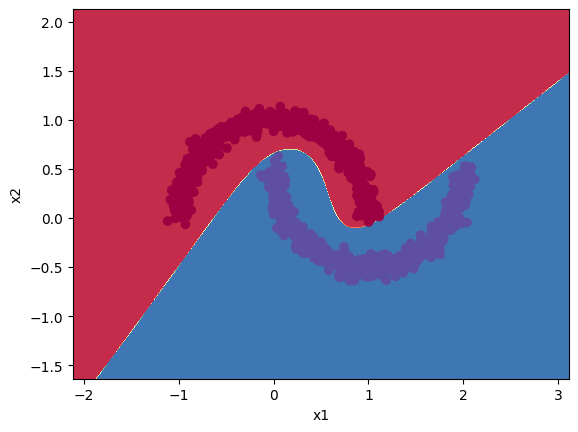

In [58]:
# part 25
plot_decision_boundary_nn(parameters_tanh_tanh_online_learningNotFix, X, y)

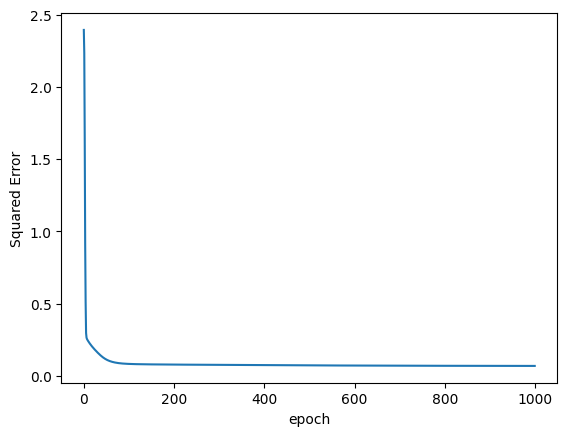

0.9066666666666666


In [59]:
# part 26
parameters_tanh_tanh_batch_learningFix=nn_model(x_train, y_train,nerun_hide=3,nerun_out=1,epochs=1000,
                                   act_hide='tanh',act_out='tanh',mode='batch',print_cost=False ,
                                   learning_rate=0.6)
print(accurecy(parameters_tanh_tanh_batch_learningFix,x_test,y_test))

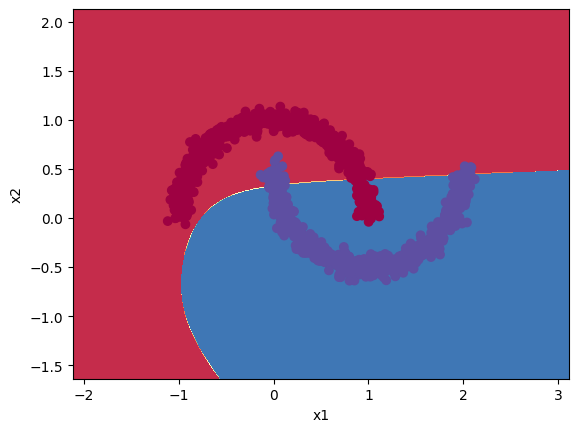

In [60]:
# part 27
plot_decision_boundary_nn(parameters_tanh_tanh_batch_learningFix, X, y)

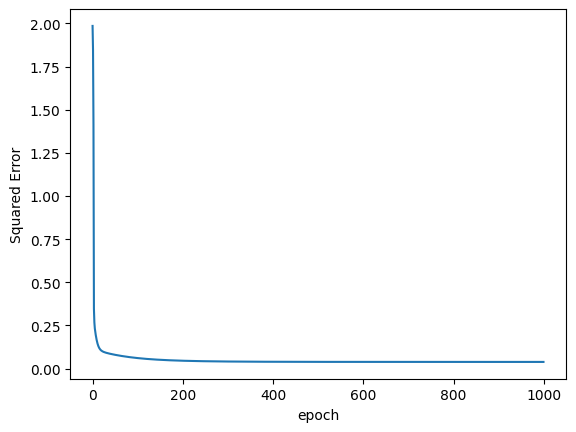

0.9733333333333334


In [61]:
# part 28
parameters_tanh_tanh_batch_learningNotFix=nn_model(x_train, y_train,nerun_hide=8,nerun_out=1,epochs=1000,
                                   act_hide='tanh',act_out='tanh',mode='batch',print_cost=False ,
                                   learning_rate=0.9,reduction_factor = 0.99)
print(accurecy(parameters_tanh_tanh_batch_learningNotFix,x_test,y_test))

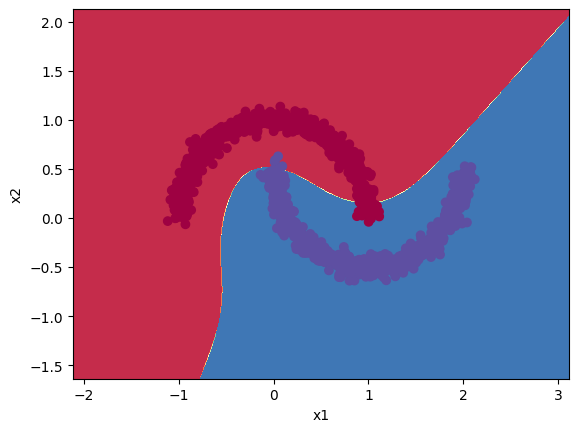

In [62]:
# part 29
plot_decision_boundary_nn(parameters_tanh_tanh_batch_learningNotFix, X, y)

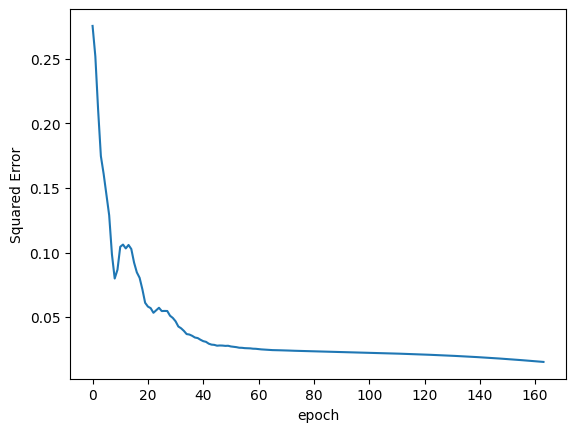

1.0


In [63]:
# part 30
parameters_tanh_tanh_batch_learningFix=nn_model(x_train, y_train,nerun_hide=3,nerun_out=1,epochs=1000,
                                   act_hide='tanh',act_out='tanh',mode='batch',print_cost=False ,
                                   learning_rate=0.68,gama=0.9)
print(accurecy(parameters_tanh_tanh_batch_learningFix,x_test,y_test))

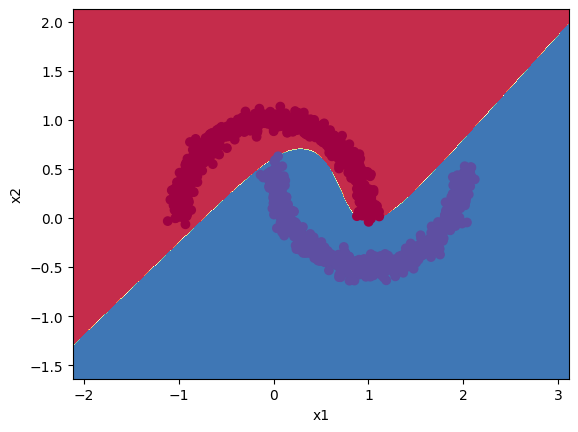

In [64]:
# part 31
plot_decision_boundary_nn(parameters_tanh_tanh_batch_learningFix, X, y)